In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [65]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline


In [2]:
#Importando Dados do Big Query

In [3]:
#Importando Dados do Big Query
from google.cloud import bigquery
from google.api_core import exceptions

key_path = "keyfile.json"

try:
    client = bigquery.Client.from_service_account_json(key_path)

    print(f"Autenticação bem-sucedida com o projeto: {client.project}")

except FileNotFoundError:
    print(f"ERRO: O arquivo de chave não foi encontrado no caminho especificado: {key_path}")
    print("Verifique se o caminho está correto.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a autenticação: {e}")
    exit()


Autenticação bem-sucedida com o projeto: viitra-redu


In [21]:
data_inicio = '2020-01-01'
data_fim = '2021-12-31'

sql_query = f"""
select
     eng.cliente
    ,eng.user_id
    ,eng.environment_id
    ,eng.course_id
    ,eng.space_id
    ,eng.subject_id
    ,eng.lecture_id
    ,eng.NivelAgregacao
    ,eng.user_name
    ,eng.environment_name
    ,eng.course_name
    ,eng.space_name
    ,eng.subject_name
    ,eng.lecture_name
    ,eng.period_start_date
    ,eng.period_end_date
    ,eng.postsAmount
    ,eng.postRepliesAmount
    ,eng.helpRequestsAmount
    ,eng.helpRequestRepliesAmount
    ,eng.performance_rate
from analytics.fn_engajamento(
  DATE('{data_inicio}'),
  DATE('{data_fim}'),
  TRUE,'redu-digital',
  73,
  NULL,
  NULL,
  NULL,
  NULL,'SPA', 'QUARTER'
) as eng
inner join (
    select 
        uea.user_id
        ,uea.cliente 
    from replicas.user_environment_associations uea 
    where uea.role not in ('teacher', 'tutor', 'environment_admin')
) as filtro on filtro.cliente = eng.cliente and filtro.user_id = eng.user_id
"""
try:
    dataframe = client.query(sql_query).to_dataframe()
    print(dataframe.head())
except exceptions.Forbidden as e:
    print(f"ERRO DE PERMISSÃO: {e}")
    print("A autenticação funcionou, mas a conta de serviço não tem permissão para acessar os dados.")
    print("Verifique os papéis de IAM (ex: 'BigQuery User') no Google Cloud Console.")

c:\Users\Matheus Monte\Documents\Classificador\env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      553              73        155       534        <NA>   
1  redu-digital      829              73        155       534        <NA>   
2  redu-digital      503              73        155       534        <NA>   
3  redu-digital      503              73        155       534        <NA>   
4  redu-digital      703              73        155       534        <NA>   

   lecture_id NivelAgregacao                         user_name  \
0        <NA>            SPA             EVELINE GOUVEIA NUNES   
1        <NA>            SPA          FELIPE DOS SANTOS MENDES   
2        <NA>            SPA            VIVIANE CORDEIRO GOMES   
3        <NA>            SPA            VIVIANE CORDEIRO GOMES   
4        <NA>            SPA  LUCIANA SANTOS GRANJA DE ANDRADE   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. Design de experiências de aprendizagem   


In [4]:
## EDA dos dados importados 

In [22]:
print(dataframe.head())
dataframe.info()

        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      553              73        155       534        <NA>   
1  redu-digital      829              73        155       534        <NA>   
2  redu-digital      503              73        155       534        <NA>   
3  redu-digital      503              73        155       534        <NA>   
4  redu-digital      703              73        155       534        <NA>   

   lecture_id NivelAgregacao                         user_name  \
0        <NA>            SPA             EVELINE GOUVEIA NUNES   
1        <NA>            SPA          FELIPE DOS SANTOS MENDES   
2        <NA>            SPA            VIVIANE CORDEIRO GOMES   
3        <NA>            SPA            VIVIANE CORDEIRO GOMES   
4        <NA>            SPA  LUCIANA SANTOS GRANJA DE ANDRADE   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. Design de experiências de aprendizagem   


In [23]:
dataframe.describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.0,13856.0,13856.0,13856.0,0.0,0.0,13856.0,13856.0,13856.0,13856.0,13856.000000
mean,1246.944573,73.0,155.0,330.0,<NA>,<NA>,0.262341,0.023456,0.001371,0.002309,0.076483
std,2534.517551,0.0,0.0,198.711725,<NA>,<NA>,1.378585,0.294957,0.040721,0.067926,0.232054
min,448.0,73.0,155.0,120.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,549.0,73.0,155.0,137.25,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,668.0,73.0,155.0,333.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,790.0,73.0,155.0,525.75,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19033.0,73.0,155.0,534.0,<NA>,<NA>,27.0,12.0,2.0,4.0,1.000000


In [24]:
valores_set = dataframe.iloc[:, 16:]

In [25]:
valores_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


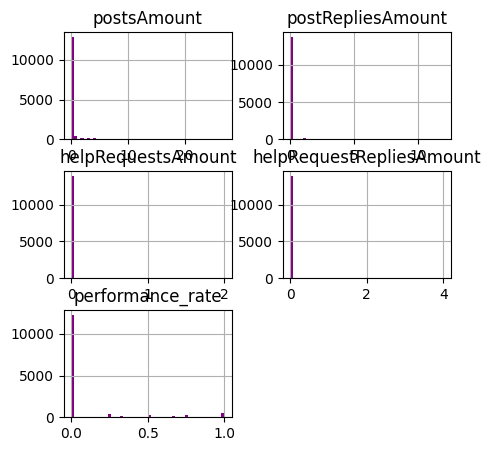

In [9]:
valores_set.hist(bins=50, figsize=(5, 5), color='purple')
plt.show()

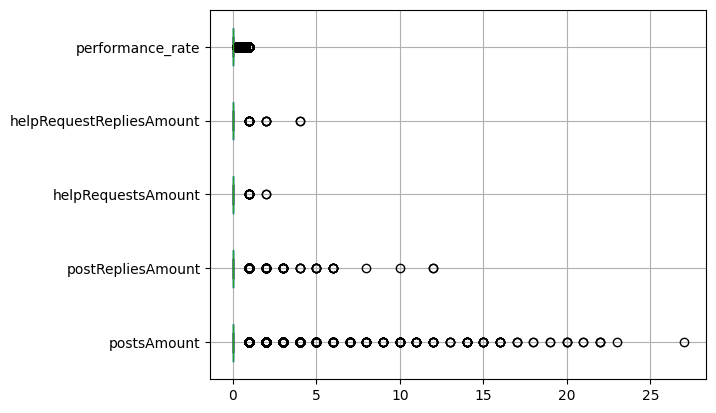

In [26]:
valores_set.boxplot(vert=False)
plt.show()

In [11]:
## pré processamento

In [27]:
train_set = valores_set.copy()

In [28]:
train_set.shape

(13856, 5)

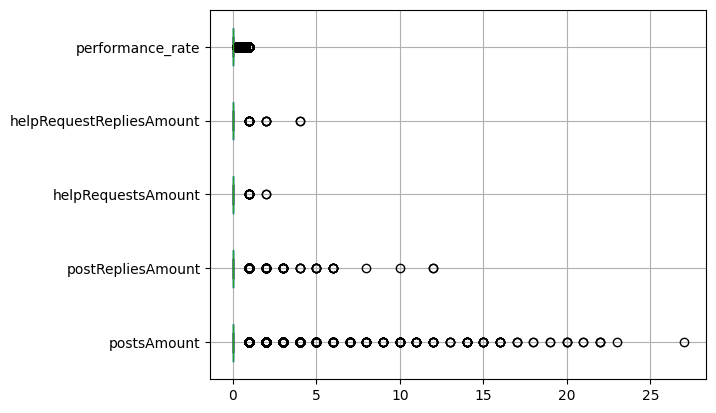

In [29]:
train_set.boxplot(vert=False)
plt.show()

In [30]:
train_set.info()
train_set.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.0,13856.0,13856.0,13856.0,13856.000000
mean,0.262341,0.023456,0.001371,0.002309,0.076483
std,1.378585,0.294957,0.040721,0.067926,0.232054
min,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.000000
max,27.0,12.0,2.0,4.0,1.000000


In [31]:
train_set.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
0,0,0,0,0,0.0
1,0,0,0,0,0.0
2,0,0,0,0,0.0
3,0,0,0,0,0.0
4,0,0,0,0,0.0


In [32]:
inputer = KNNImputer(n_neighbors=5)
inputer.fit(train_set)

,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [33]:
train_set_inpute = inputer.transform(train_set)

In [34]:
train_set_inputado = pd.DataFrame(
    train_set_inpute,
    columns=train_set.columns,
    index=train_set.index
)

In [35]:
train_set = train_set_inputado.copy()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
dtypes: float64(5)
memory usage: 541.4 KB


In [36]:
train_set.describe()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.000000,13856.000000,13856.000000,13856.000000,13856.000000
mean,0.262341,0.023456,0.001371,0.002309,0.076483
std,1.378585,0.294957,0.040721,0.067926,0.232054
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,27.000000,12.000000,2.000000,4.000000,1.000000


In [37]:
print(train_set.columns)

Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate'],
      dtype='object')


In [23]:
#performance_rate = train_set['performance_rate']

#train_Set = train_set.drop('performance_rate', axis=1)

In [38]:
scaler = MinMaxScaler()
#feature_range=(-1, 1)
train_set_scaled_np = scaler.fit_transform(train_set)

In [39]:
train_set_scaled = pd.DataFrame(
train_set_scaled_np,
    columns=train_set.columns,
    index=train_set.index
)

In [26]:
#train_set['performance_rate'] = performance_rate

In [40]:
train_set = train_set_scaled.copy()

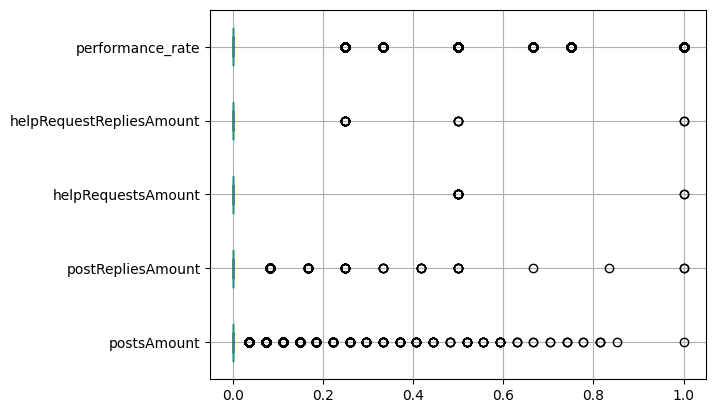

In [41]:
train_set.boxplot(vert=False)
plt.show()

In [29]:
#test_cols = test_set.columns
#test_idx = test_set.index

#test_set = pd.DataFrame(imputer.transform(test_set), columns=test_cols, index=test_idx)
#test_set = pd.DataFrame(scaler.transform(test_set), columns=test_cols, index=test_idx)

In [42]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set, labels))
    calinski.append(calinski_harabasz_score(train_set, labels))
    davies.append(davies_bouldin_score(train_set, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set)
    bic.append(gmm.bic(train_set))

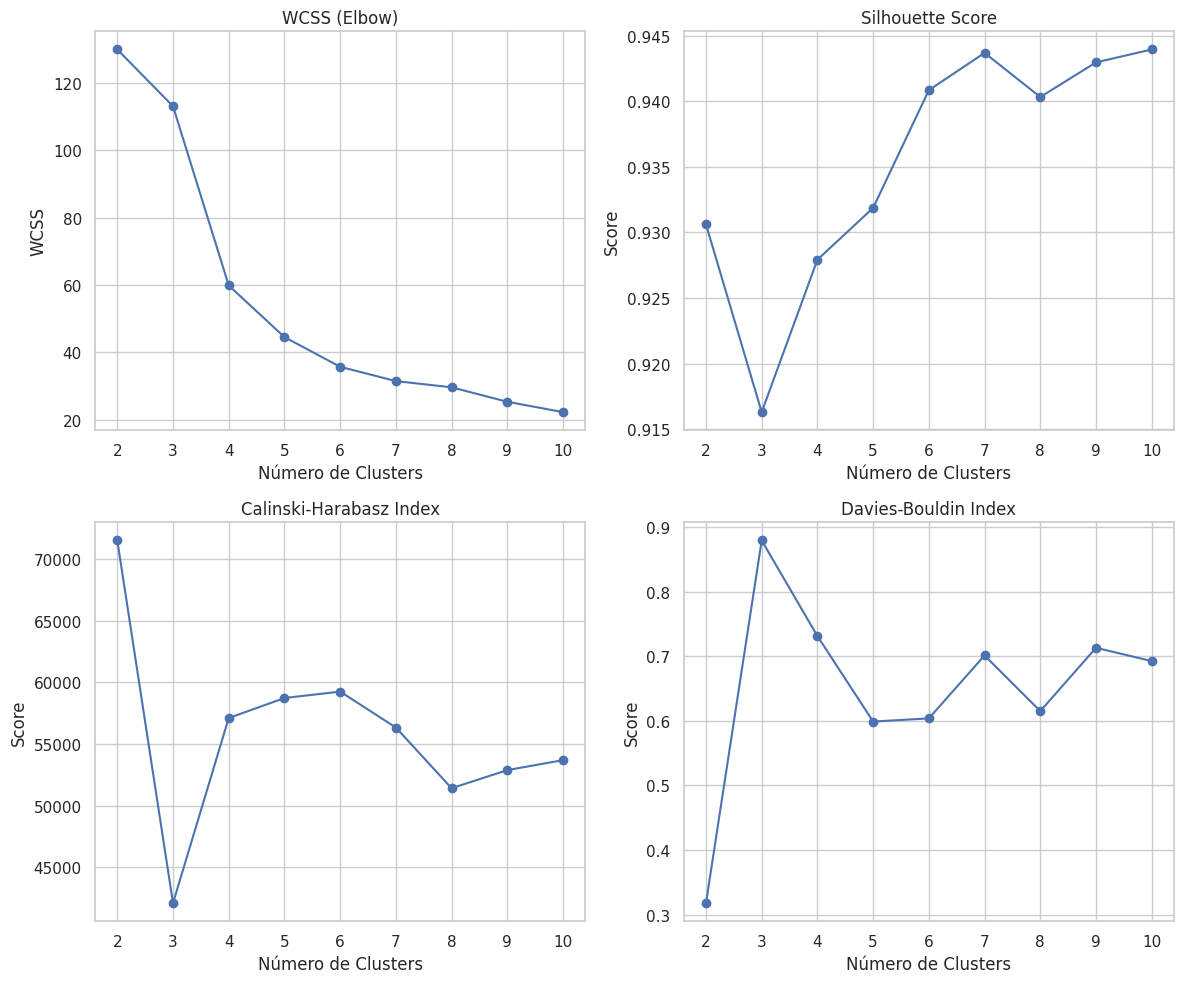

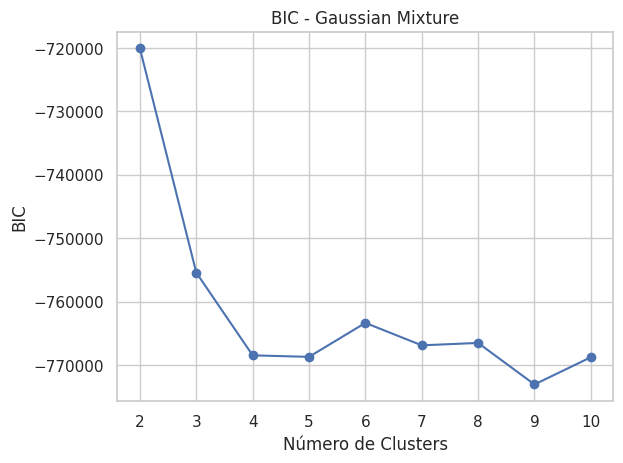

In [31]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
plt.figure()
plt.plot(k_range, bic, marker='o')
plt.title('BIC - Gaussian Mixture')
plt.xlabel('Número de Clusters')
plt.ylabel('BIC')
plt.show()


In [46]:
# Redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_set)

In [47]:
feature_names =  train_set.columns.tolist()
importancia = pd.DataFrame(
    data=pca.components_,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(2)]
)

print("Contribuição das variáveis em cada Componente Principal:")
print(importancia.T)

# Variância explicada por componente
print("\nVariância explicada por cada componente:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

Contribuição das variáveis em cada Componente Principal:
                               PC1       PC2
postsAmount               0.095459  0.960881
postRepliesAmount         0.020450  0.241857
helpRequestsAmount        0.003453  0.071654
helpRequestRepliesAmount  0.002145  0.059739
performance_rate          0.995215 -0.097513

Variância explicada por cada componente:
PC1: 94.09%
PC2: 3.90%


In [48]:
# Treinamento do K-Means
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(X_pca)

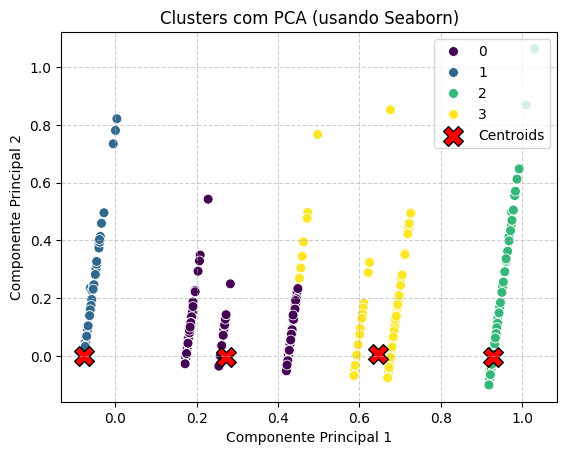

In [49]:
# 1. (Opcional mas recomendado) Coloque seus dados em um DataFrame do Pandas
df_pca = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': y_kmeans
})

# 2. Use o scatterplot do Seaborn
# O parâmetro 'hue' diz ao Seaborn para colorir os pontos com base na coluna 'Cluster'
# e criar uma legenda automaticamente.
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)

# 3. Plotar os centróides por cima (usando Matplotlib)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', label='Centroids', marker='X', edgecolors='black')

# 4. Adicionar título e customizações
plt.title('Clusters com PCA (usando Seaborn)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [50]:
tabela_contagem = pd.Series(y_kmeans).value_counts()


# Exibe a tabela final
print("Quantidade de itens por cluster:")
print(tabela_contagem)

Quantidade de itens por cluster:
1    12213
0      728
2      531
3      384
Name: count, dtype: int64


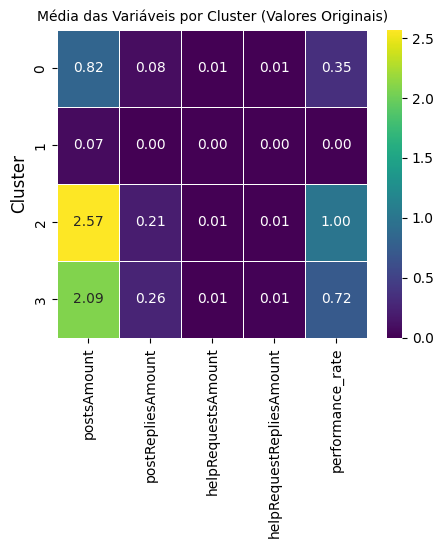

In [51]:
dados_revertidos_np = scaler.inverse_transform(train_set)
train_set_revertido = pd.DataFrame(dados_revertidos_np, columns=train_set.columns, index=train_set.index)

dados_originais_com_clusters = train_set_revertido.copy()
dados_originais_com_clusters['cluster'] = y_kmeans
cluster_means = dados_originais_com_clusters.groupby('cluster').mean()

#cluster_means_para_plotar = cluster_means

plt.figure(figsize=(5, 4))

sns.heatmap(
    cluster_means,
    
    annot=True,
    fmt='.2f',
    cmap='viridis',
    linewidths=.5
)

plt.title('Média das Variáveis por Cluster (Valores Originais)', fontsize=10)
plt.ylabel('Cluster', fontsize=12)
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate <= 0.12
|   |--- class: 1
|--- performance_rate >  0.12
|   |--- performance_rate <= 0.58
|   |   |--- postsAmount <= 0.31
|   |   |   |--- class: 0
|   |   |--- postsAmount >  0.31
|   |   |   |--- class: 3
|   |--- performance_rate >  0.58
|   |   |--- performance_rate <= 0.88
|   |   |   |--- class: 3
|   |   |--- performance_rate >  0.88
|   |   |   |--- class: 2


--- Visualização da Árvore ---


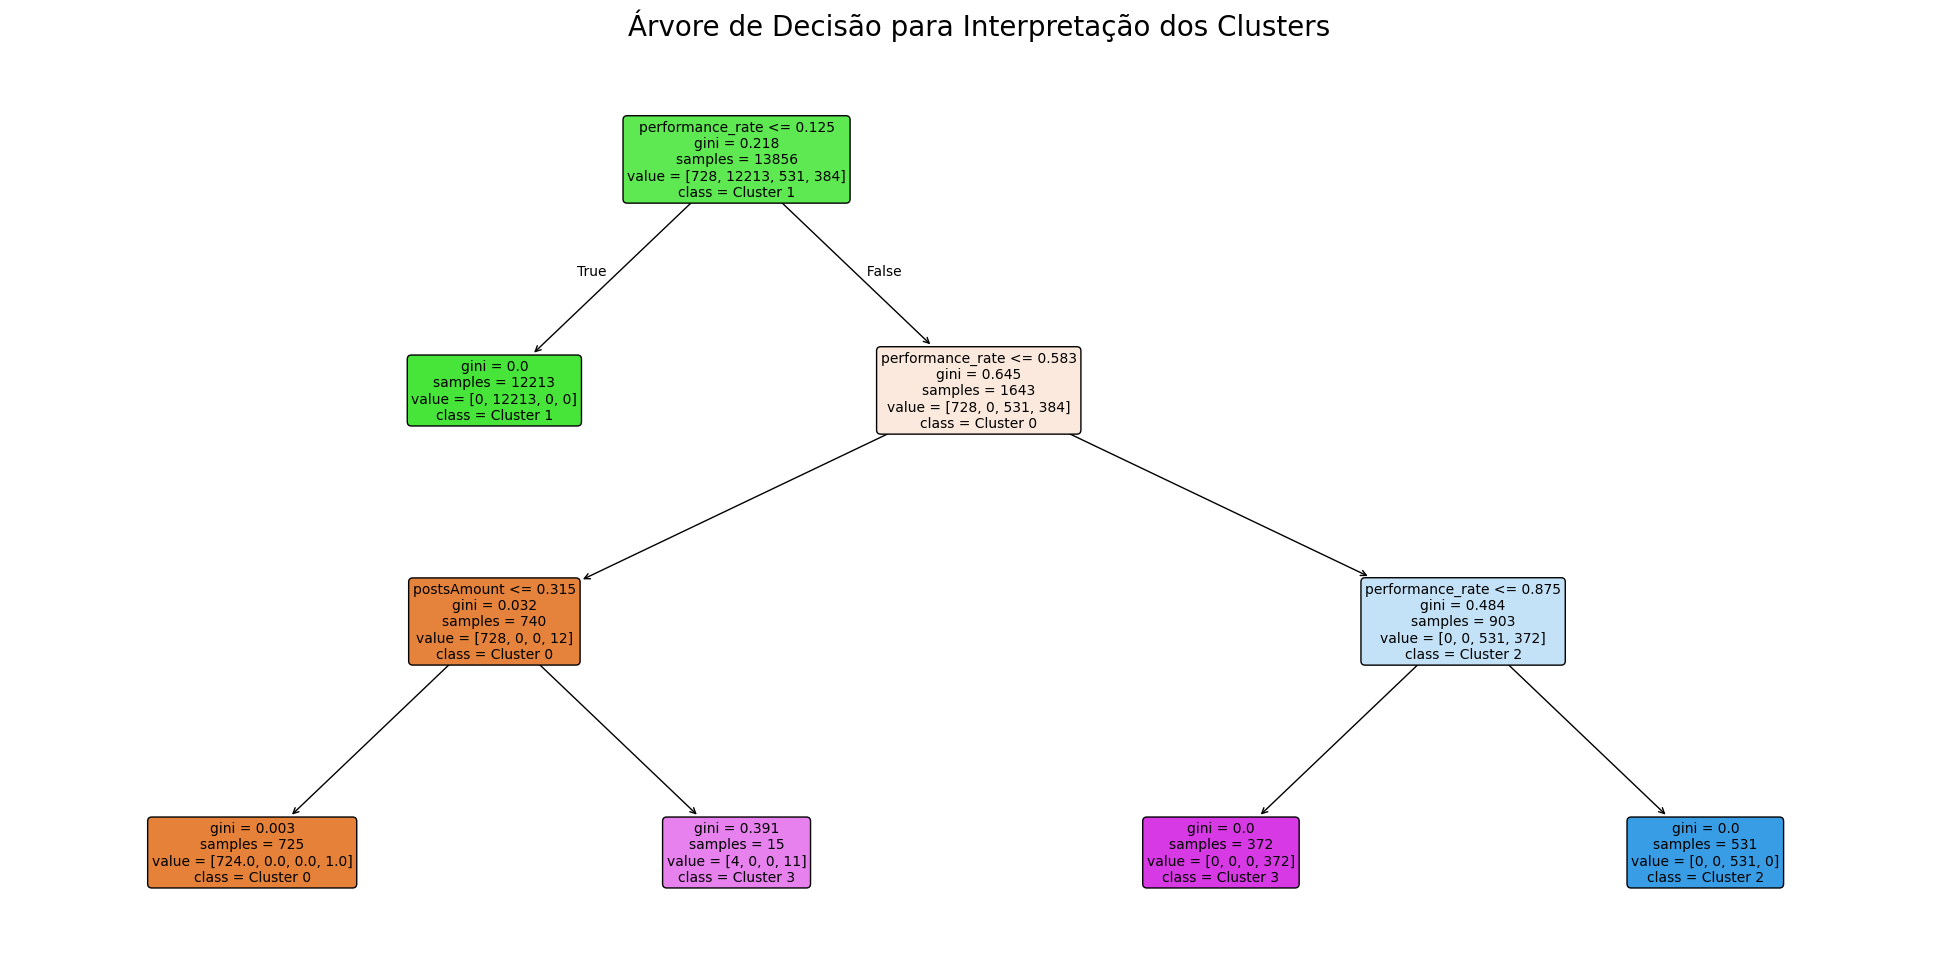

In [52]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

# Definir as features (X) e o alvo (y)
X = train_set
y = y_kmeans

# Inicializar o classificador.
# max_depth=3 significa que teremos no máximo 3 níveis de regras. É ótimo para interpretação.
# random_state garante que o resultado seja o mesmo toda vez.
arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treinar a árvore para aprender a mapear as features para os clusters
arvore_de_decisao.fit(X, y)


# --- 3. EXTRAIR E VISUALIZAR AS REGRAS ---

# Método 1: Extrair as regras como texto (muito útil!)
print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


# Método 2: Visualizar a árvore de decisão (ainda mais intuitivo)
print("\n--- Visualização da Árvore ---")
# Nomes das classes para a legenda do gráfico
nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True,  # Colore os nós para indicar a classe majoritária
    rounded=True, # Deixa os nós com cantos arredondados
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

In [53]:

train_set['cluster'] = y_kmeans

centroids_interpretacao_df = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids_interpretacao_df)
print("-" * 50)

mapa_de_labels = {}

id_consistente = centroids_interpretacao_df['postsAmount'].idxmax()
mapa_de_labels[id_consistente] = "Engajamento consistente"

# "Não interagem": Menor performance rate
id_nao_interagem = centroids_interpretacao_df['performance_rate'].idxmin()
mapa_de_labels[id_nao_interagem] = "não interagem"

# Identifica e classifica os dois clusters restantes
indices_restantes = [c for c in centroids_interpretacao_df.index if c not in mapa_de_labels]

if centroids_interpretacao_df.loc[indices_restantes[0], 'performance_rate'] > centroids_interpretacao_df.loc[indices_restantes[1], 'performance_rate']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[1]] = "Desempenho crítico"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento excelente"
    mapa_de_labels[indices_restantes[0]] = "Desempenho crítico"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
print(mapa_de_labels)

# Passo 4: Aplicar o mapa gerado
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.030525           0.006868            0.003434   
1           0.002638           0.000382            0.000368   
2           0.095138           0.017263            0.002825   
3           0.077257           0.021484            0.002604   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.002404          0.347756  
1                        0.000348          0.000000  
2                        0.001412          1.000000  
3                        0.003255          0.717665  
--------------------------------------------------

--- Mapa de Labels Gerado Automaticamente ---
{np.int32(2): 'Engajamento consistente', np.int32(1): 'não interagem', 3: 'Engajamento excelente', 0: 'Desempenho crítico'}

--- Contagem final das 

In [54]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.0,0.0,0.0,0.0,0.0,1,não interagem
1,0.0,0.0,0.0,0.0,0.0,1,não interagem
2,0.0,0.0,0.0,0.0,0.0,1,não interagem
3,0.0,0.0,0.0,0.0,0.0,1,não interagem
4,0.0,0.0,0.0,0.0,0.0,1,não interagem


In [55]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
13851,0.0,0.0,0.0,0.0,0.00,1,não interagem
13852,0.0,0.0,0.0,0.0,0.00,1,não interagem
13853,0.0,0.0,0.0,0.0,0.75,3,Engajamento excelente
13854,0.0,0.0,0.0,0.0,0.00,1,não interagem
13855,0.0,0.0,0.0,0.0,0.00,1,não interagem


In [56]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
 5   cluster                   13856 non-null  int32  
 6   categoria_interacao       13856 non-null  object 
dtypes: float64(5), int32(1), object(1)
memory usage: 703.8+ KB


In [57]:
dataframe['categoria_engajamento'] = dataset_clss['categoria_interacao']

In [58]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,subject_name,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento
0,redu-digital,553,73,155,534,<NA>,<NA>,SPA,EVELINE GOUVEIA NUNES,SENAC-PE,...,None,None,2021-04-01,2021-06-30,0,0,0,0,0.0,não interagem
1,redu-digital,829,73,155,534,<NA>,<NA>,SPA,FELIPE DOS SANTOS MENDES,SENAC-PE,...,None,None,2021-01-01,2021-03-31,0,0,0,0,0.0,não interagem
2,redu-digital,503,73,155,534,<NA>,<NA>,SPA,VIVIANE CORDEIRO GOMES,SENAC-PE,...,None,None,2021-07-01,2021-09-30,0,0,0,0,0.0,não interagem
3,redu-digital,503,73,155,534,<NA>,<NA>,SPA,VIVIANE CORDEIRO GOMES,SENAC-PE,...,None,None,2021-07-01,2021-09-30,0,0,0,0,0.0,não interagem
4,redu-digital,703,73,155,534,<NA>,<NA>,SPA,LUCIANA SANTOS GRANJA DE ANDRADE,SENAC-PE,...,None,None,2020-04-01,2020-06-30,0,0,0,0,0.0,não interagem


In [59]:
dataframe['data_inicio'] = pd.to_datetime(data_inicio).date()
dataframe['data_fim'] = pd.to_datetime(data_fim).date()


# Passo 2: Adicionar a data de hoje como data da classificação
# A função date.today() captura a data atual em que o código é executado.
dataframe['data_classificacao'] = date.today()

In [60]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento,data_inicio,data_fim,data_classificacao
0,redu-digital,553,73,155,534,<NA>,<NA>,SPA,EVELINE GOUVEIA NUNES,SENAC-PE,...,2021-06-30,0,0,0,0,0.0,não interagem,2020-01-01,2021-12-31,2025-08-28
1,redu-digital,829,73,155,534,<NA>,<NA>,SPA,FELIPE DOS SANTOS MENDES,SENAC-PE,...,2021-03-31,0,0,0,0,0.0,não interagem,2020-01-01,2021-12-31,2025-08-28
2,redu-digital,503,73,155,534,<NA>,<NA>,SPA,VIVIANE CORDEIRO GOMES,SENAC-PE,...,2021-09-30,0,0,0,0,0.0,não interagem,2020-01-01,2021-12-31,2025-08-28
3,redu-digital,503,73,155,534,<NA>,<NA>,SPA,VIVIANE CORDEIRO GOMES,SENAC-PE,...,2021-09-30,0,0,0,0,0.0,não interagem,2020-01-01,2021-12-31,2025-08-28
4,redu-digital,703,73,155,534,<NA>,<NA>,SPA,LUCIANA SANTOS GRANJA DE ANDRADE,SENAC-PE,...,2020-06-30,0,0,0,0,0.0,não interagem,2020-01-01,2021-12-31,2025-08-28


In [47]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente                   13856 non-null  object 
 1   user_id                   13856 non-null  Int64  
 2   environment_id            13856 non-null  Int64  
 3   course_id                 13856 non-null  Int64  
 4   space_id                  13856 non-null  Int64  
 5   subject_id                0 non-null      Int64  
 6   lecture_id                0 non-null      Int64  
 7   NivelAgregacao            13856 non-null  object 
 8   user_name                 13856 non-null  object 
 9   environment_name          13856 non-null  object 
 10  course_name               13856 non-null  object 
 11  space_name                13856 non-null  object 
 12  subject_name              0 non-null      object 
 13  lecture_name              0 non-null      object 
 14  period

In [ ]:
# # Define o nome completo da tabela de destino
# table_id = "viitra-redu.analytics.cubo_engajamento"

# # Prepara o DataFrame para envio
# df_to_load = dataframe.copy()
# df_to_load = df_to_load.rename(columns={
#     'categoria_interacao': 'categoria_engajamento',
#     'data_inicio_consulta': 'data_inicio',
#     'data_fim_consulta': 'data_fim'
# })

# # Converte as colunas de data para o tipo datetime do pandas, a forma mais robusta
# date_columns = ['data_inicio', 'data_fim', 'data_classificacao']
# for col in date_columns:
#     if col in df_to_load.columns:
#         df_to_load[col] = pd.to_datetime(df_to_load[col])

# # Garante que o DataFrame tenha apenas as colunas da tabela de destino
# schema_columns = [
#     'cliente', 'user_id', 'environment_id', 'course_id', 'space_id', 
#     'subject_id', 'lecture_id', 'NivelAgregacao', 'user_name', 
#     'environment_name', 'course_name', 'space_name', 'subject_name', 
#     'lecture_name', 'postsAmount', 'postRepliesAmount', 
#     'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate', 
#     'categoria_engajamento', 'data_inicio', 'data_fim', 'data_classificacao'
# ]
# df_to_load = df_to_load[schema_columns]

# # Configura o job para adicionar os dados (append)
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")

# print(f"Iniciando o carregamento de {len(df_to_load)} registros para a tabela {table_id}...")

# try:
#     # Envia o DataFrame para o BigQuery e aguarda a conclusão
#     load_job = client.load_table_from_dataframe(
#         df_to_load, table_id, job_config=job_config
#     )
#     load_job.result()
#     print("Carregamento concluído com sucesso!")
#     print(f"Foram carregadas {load_job.output_rows} linhas.")

# except Exception as e:
#     print(f"Ocorreu um erro durante o carregamento: {e}")
#     if 'load_job' in locals() and load_job.errors:
#         print("Detalhes do erro do BigQuery:", load_job.errors)

# # Executa uma consulta de verificação no BigQuery
# print("\nVerificação dos dados inseridos hoje no BigQuery:")
# query = f"""
#     SELECT data_classificacao, COUNT(1) as total_registros
#     FROM `{table_id}`
#     WHERE data_classificacao = CURRENT_DATE('America/Sao_Paulo')
#     GROUP BY 1
# """
# results_df = client.query(query).to_dataframe()
# print(results_df)

Iniciando o carregamento de 13856 registros para a tabela viitra-redu.analytics.cubo_engajamento...
Carregamento concluído com sucesso!
Foram carregadas 13856 linhas.

Verificação dos dados inseridos hoje no BigQuery:
  data_classificacao  total_registros
0         2025-08-28            27712


In [ ]:
#Treinamento supervisionado 

In [61]:
df = dataframe.copy()

In [62]:
# 1. Crie uma cópia do DataFrame para análise
df_analysis = df.copy()

# 2. Codifique a variável-alvo para um formato numérico para calcular a correlação
le = LabelEncoder()
df_analysis['target_encoded'] = le.fit_transform(df_analysis['categoria_engajamento'])

# 3. Defina as features que você usou no modelo
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']

# 4. Calcule a correlação de cada feature com o alvo codificado
correlations = df_analysis[features + ['target_encoded']].corr()

print("Correlação das Features com a Variável-Alvo:")
print(correlations['target_encoded'].sort_values(ascending=False))

Correlação das Features com a Variável-Alvo:
target_encoded              1.000000
helpRequestRepliesAmount   -0.032802
helpRequestsAmount         -0.041755
postRepliesAmount          -0.132374
postsAmount                -0.299520
performance_rate           -0.739714
Name: target_encoded, dtype: float64


In [63]:
# =============================================================================
# PASSO 2: DEFINIÇÃO DAS FEATURES E DIVISÃO EM TREINO, VALIDAÇÃO E TESTE
# =============================================================================
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']
target = 'categoria_engajamento'
X = df[features]
y = df[target]

# Divisão dos dados (em formato de texto para 'y')
X_train_full, X_test, y_train_full_text, y_test_text = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train_text, y_val_text = train_test_split(
    X_train_full, y_train_full_text, test_size=0.25, random_state=42, stratify=y_train_full_text
)


In [ ]:
# =============================================================================
# PASSO 3: PRÉ-PROCESSAMENTO COM PIPELINE (CORREÇÃO)
# =============================================================================
# Criamos um pipeline que executa a imputação e o escalonamento em sequência
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- APRENDENDO (fit) SOMENTE com os dados de TREINO ---
# O pipeline aprende as regras de imputação e escalonamento de uma só vez
preprocessor.fit(X_train)
print("Pipeline de pré-processamento treinado.")

# --- APLICANDO (transform) as regras aprendidas em TODOS os conjuntos ---
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print("Todos os conjuntos de features foram pré-processados pelo pipeline.")

# --- Codificação do Alvo (Label Encoding) - Feito separadamente ---
le = LabelEncoder()
le.fit(y_train_text)
y_train = le.transform(y_train_text)
y_val = le.transform(y_val_text)
y_test = le.transform(y_test_text)
target_classes = le.classes_
print("-" * 40)

Pipeline de pré-processamento treinado.
Todos os conjuntos de features foram pré-processados pelo pipeline.
----------------------------------------


In [ ]:
# =============================================================================
# PASSO 4: BALANCEAMENTO DE CLASSES (APENAS NO CONJUNTO DE TREINO)
# =============================================================================
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
print("Conjunto de treino balanceado com SMOTE.")
print("-" * 40)

# =============================================================================
# PASSO 5 E 6: OTIMIZAÇÃO, TREINO E AVALIAÇÃO (Sem alterações aqui)
# =============================================================================
# (O restante do código para otimização e avaliação permanece o mesmo)

# OTIMIZAÇÃO MANUAL...
param_grid = {'n_estimators': [50, 100], 'max_depth': [5, 10, 15], 'min_samples_leaf': [5, 10, 15]}
best_accuracy = 0.0
best_params = {}

for n_est in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        for leaf in param_grid['min_samples_leaf']:
            model = RandomForestClassifier(
                n_estimators=n_est, max_depth=depth, min_samples_leaf=leaf,
                random_state=42, n_jobs=-1
            )
            model.fit(X_train_balanced, y_train_balanced)
            accuracy = model.score(X_val_processed, y_val)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': leaf}
print(f"Melhores parâmetros encontrados: {best_params}")
print("-" * 40)
printf

Conjunto de treino balanceado com SMOTE.
----------------------------------------
Melhores parâmetros encontrados: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 10}
----------------------------------------


AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

                         precision    recall  f1-score   support

     Desempenho crítico       0.97      1.00      0.99       146
Engajamento consistente       1.00      1.00      1.00       106
  Engajamento excelente       1.00      0.95      0.97        77
          não interagem       1.00      1.00      1.00      2443

               accuracy                           1.00      2772
              macro avg       0.99      0.99      0.99      2772
           weighted avg       1.00      1.00      1.00      2772



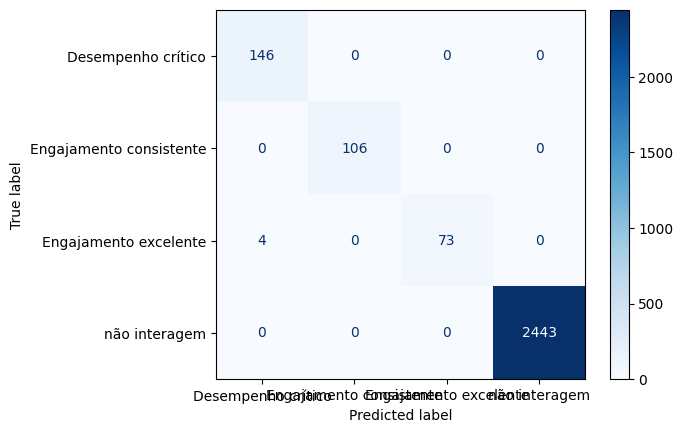

In [70]:
# AVALIAÇÃO FINAL...
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train_balanced, y_train_balanced)
y_pred = final_model.predict(X_test_processed)
print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE\n")
print(classification_report(y_test, y_pred, target_names=target_classes))
disp = ConfusionMatrixDisplay.from_estimator(final_model, X_test_processed, y_test, display_labels=target_classes, cmap=plt.cm.Blues)
plt.show()